In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.integrate

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def system(t,z):
  q1 = z[0:1]
  q2 = z[1:2]
  p1 = z[2:3]
  p2 = z[3:4]

  dqdt = np.concatenate([5*p1-p2, -p1+5*p2])
  dpdt = np.concatenate([-q1*q1*q1-q2, -q2*q2*q2-q1])
  return np.concatenate([dqdt,dpdt])

In [ ]:
#Make the dataset
N = 1000
s = 2
M = 10 #number of sampled points (after final time)
T = 0.3 #final sampling time
time = np.linspace(0,T,M)
dt = time[1] - time[0]

q = np.random.randn(N,s)  #we suppose them organized as z = [q1,...,qs,p1,...,ps]
p = np.random.randn(N,s)
z = np.concatenate([q,p],axis=1)

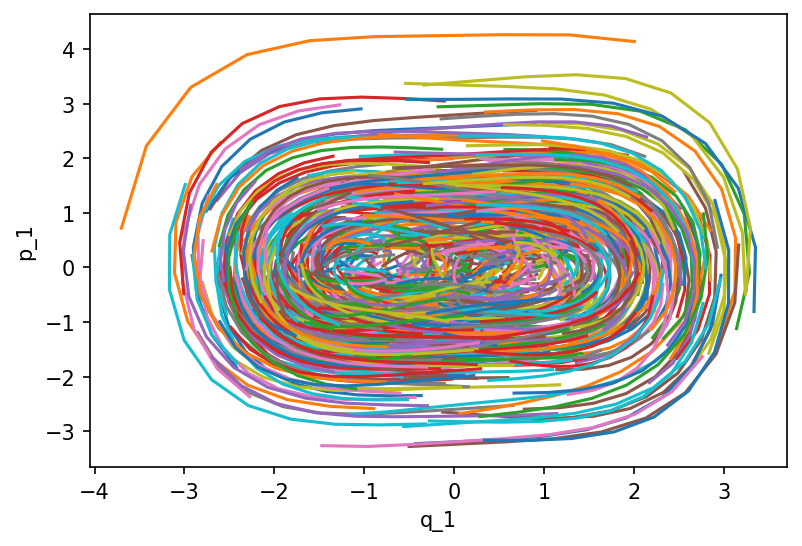

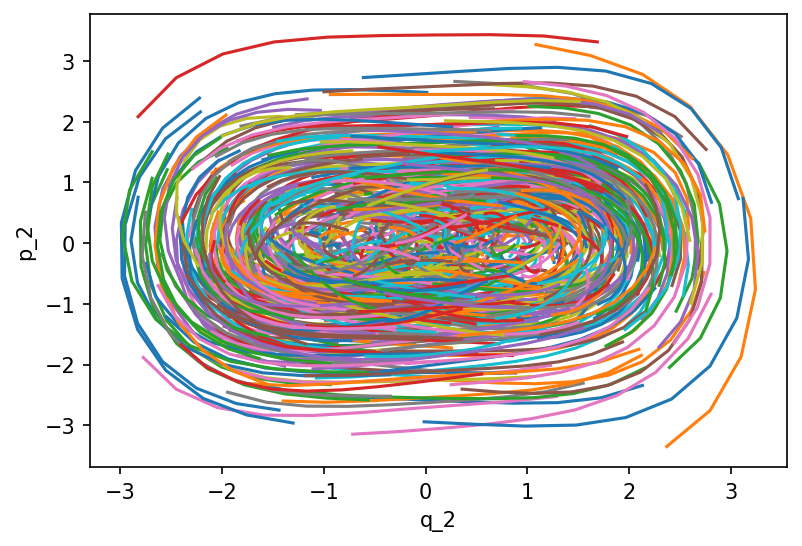

In [ ]:
timeEval = np.linspace(0,T,M)

traj = np.zeros([N,2*s,len(timeEval)])
for i in range(N):
  traj[i,:,:] = scipy.integrate.solve_ivp(system,[0, T],z[i],method='RK45',t_eval=timeEval,rtol=1e-11,atol=1e-13).y

fig, ax = plt.subplots(dpi=150)
for i in range(N):
  ax.plot(traj[i,0],traj[i,2])
  ax.set_xlabel("q_1")
  ax.set_ylabel("p_1")
plt.show()
fig, ax = plt.subplots(dpi=150)
for i in range(N):
  ax.plot(traj[i,1],traj[i,3])
  ax.set_xlabel("q_2")
  ax.set_ylabel("p_2")
plt.show()

In [ ]:
X = traj[:,:,0]
Y = traj[:,:,1:M]
Ntrain = int(0.9 * N)

In [ ]:

from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.astype(np.float32)).to(device)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X[:Ntrain,:],Y[:Ntrain])
testset = dataset(X[Ntrain:,:], Y[Ntrain:])

In [ ]:
batch_size = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [ ]:
K = 50
Nl = 2

class Hamiltonian(nn.Module):
    def __init__(self, ):
        super(Hamiltonian, self).__init__()
        
        self.IV = nn.Linear(s,K) 
        self.nl = nn.Tanh()
        
        lin = []
        for i in range(Nl):
          lin.append(nn.Linear(K,K))
          lin.append(self.nl)
        self.seqTr = nn.Sequential(*lin)

        self.OV = nn.Linear(K,1)

        self.A = torch.nn.Parameter(data=torch.Tensor(s,s)) #so that 0.5 * p^T(A^TA)p = K(p)
        self.A.data.copy_(torch.rand(s,s))
        self.A.to(device)
        
    def Kinetic(self, X):
        k = (0.5 * torch.linalg.norm(X[:,s:]@torch.transpose(self.A,0,1),axis=1)**2).unsqueeze(1)
        return k
    
    def Potential(self, X):
        z = self.nl(self.IV(X[:,0:s])) #first affine+nonliner mapping
        z = self.seqTr(z)
        v = self.OV(z) #output transformation
        return v

    def forward(self, X):
        o = self.Potential(X) + self.Kinetic(X)
        return o

### Training with regularization

In [ ]:
Ham = Hamiltonian()
Ham.to(device)

Hamiltonian(
  (IV): Linear(in_features=2, out_features=50, bias=True)
  (nl): Tanh()
  (seqTr): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
  )
  (OV): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
#Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Ham.parameters(), lr = 0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [ ]:
I = torch.eye(s)
Z = torch.zeros([s,s])
J1 = torch.cat([Z,I],axis=1)
J2 = torch.cat([-I,Z],axis=1)
J = torch.cat([J1,J2],axis = 0).to(device) #Symplectic matrix
print(J)

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0.,  0.,  0.],
        [-0., -1.,  0.,  0.]], device='cuda:0')


In [ ]:
def ExpEuler(x0):
  N = len(x0) #number of points I propagate in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1]).to(device)
  for i in range(M-1):
    H = torch.sum(Ham(x)).to(device)
    dH = torch.autograd.grad(H, x, create_graph=True)[0].to(device)
    dHtranspose = torch.transpose(dH,0,1).to(device)
    XH= (J@dHtranspose).t().to(device) #compute the Hamiltonian vector field

    x = x + dt * XH 
    sol[:,:,i] = x.to(device)
  
  return(sol) #stored trajectories

def StormerVerlet(x0):
  N = len(x0) #number of points I propagate in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1 ]).to(device)
  for i in range(M-1):

    #x@Mat1 = [0,x[:,1]], x@Mat0 = [x[:,0],0]
    #q@N0 = [q,0] e p@N1 = [0,p]
    id = torch.eye(s)
    zz = torch.zeros((s,s))
    
    N0 = torch.cat((id,zz),axis=1).to(device)
    N1 = torch.cat((zz,id),axis=1).to(device)

    H = torch.sum(Ham(x))
    dH = torch.autograd.grad(H, x, create_graph=True)[0].to(device)
    dHtranspose = torch.transpose(dH,0,1).to(device)
    XH= (J@dHtranspose).t().to(device) #compute the Hamiltonian vector field
    x = x + dt/2 * (XH[:,s:2*s])@N1 #update p to phalf


    H1 = torch.sum(Ham(x))
    dH1 = torch.autograd.grad(H1, x, create_graph=True)[0].to(device)
    dHtranspose1 = torch.transpose(dH1,0,1).to(device)
    XH1= (J@dHtranspose1).t().to(device) #compute the Hamiltonian vector field
    x = x + dt * (XH1[:,0:s])@N0 #update for q 


    H2 = torch.sum(Ham(x))
    dH2 = torch.autograd.grad(H2, x, create_graph=True)[0].to(device)
    dHtranspose2 = torch.transpose(dH2,0,1).to(device)
    XH2= (J@dHtranspose2).t().to(device) #compute the Hamiltonian vector field

    x = x + dt/2 * (XH2[:,s:2*s])@N1 #update phalf to pnew
    sol[:,:,i] = x
  return(sol) #stored trajectories

In [ ]:
integrator = StormerVerlet

In [ ]:
checkpoint = 20

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    gamma =  0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs.requires_grad_()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted = integrator(inputs)
        HamConservation = torch.sum(torch.abs(Ham(inputs)-Ham(labels[:,:,-1]))) 
        loss = criterion(predicted, labels) + gamma * HamConservation
        #print(loss)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

    scheduler.step()
    #if epoch%10 == 0 and epoch>0:
    #  lr=optimizer.param_groups[0]["lr"]
    #  print(f"\n\nLR: {lr}, EPOCH: {epoch}\n\n")

print('Finished Training')

[1,     1] loss: 0.0301778644
[2,     1] loss: 0.0260816038
[3,     1] loss: 0.0192335755
[4,     1] loss: 0.0144617170
[5,     1] loss: 0.0155521169
[6,     1] loss: 0.0137300417
[7,     1] loss: 0.0096426018
[8,     1] loss: 0.0086439855
[9,     1] loss: 0.0059556879
[10,     1] loss: 0.0032890793
[11,     1] loss: 0.0021870436
[12,     1] loss: 0.0006701273
[13,     1] loss: 0.0002674878
[14,     1] loss: 0.0003179018
[15,     1] loss: 0.0002173894
[16,     1] loss: 0.0003647617
[17,     1] loss: 0.0001338745
[18,     1] loss: 0.0004885484
[19,     1] loss: 0.0003291711
[20,     1] loss: 0.0001070893
[21,     1] loss: 0.0001118863
[22,     1] loss: 0.0001139892
[23,     1] loss: 0.0000653881
[24,     1] loss: 0.0000620715
[25,     1] loss: 0.0000184395
[26,     1] loss: 0.0001525871
[27,     1] loss: 0.0000098727
[28,     1] loss: 0.0000199945
[29,     1] loss: 0.0000315915
[30,     1] loss: 0.0000270565
[31,     1] loss: 0.0000485636
[32,     1] loss: 0.0000271817
[33,     1] loss:

In [ ]:
print(f"A: ",torch.transpose(Ham.A,0,1)@Ham.A)

A:  tensor([[ 4.9831, -0.9988],
        [-0.9988,  4.9832]], device='cuda:0', grad_fn=<MmBackward0>)


In [ ]:
#if i = 1 it returns q1,p1, if i=2 it returns q2,p2 eventually for all the times available
def get_i(z,i):
  if len(z.shape)==2:
    qi = z[:,0+i-1:1+i-1].reshape(-1,1,1)
    pi = z[:,2+i-1:3+i-1].reshape(-1,1,1)
    return np.concatenate([qi,pi],axis=1)
  if len(z.shape)==3:
    qi = z[:,0+i-1:1+i-1,:]
    pi = z[:,2+i-1:3+i-1,:]
    return np.concatenate([qi,pi],axis=1)

In [ ]:
TT = 1
timeEval = np.linspace(0,TT,20)

In [ ]:
def perdictedModel(t,x):
  z = torch.from_numpy(x.astype(np.float32)).to(device).requires_grad_()
  uu = Ham(z.unsqueeze(0))
  dHy = torch.autograd.grad(uu,z)[0].t()
  XHH = (J@dHy).t().cpu().detach().numpy()
  return XHH

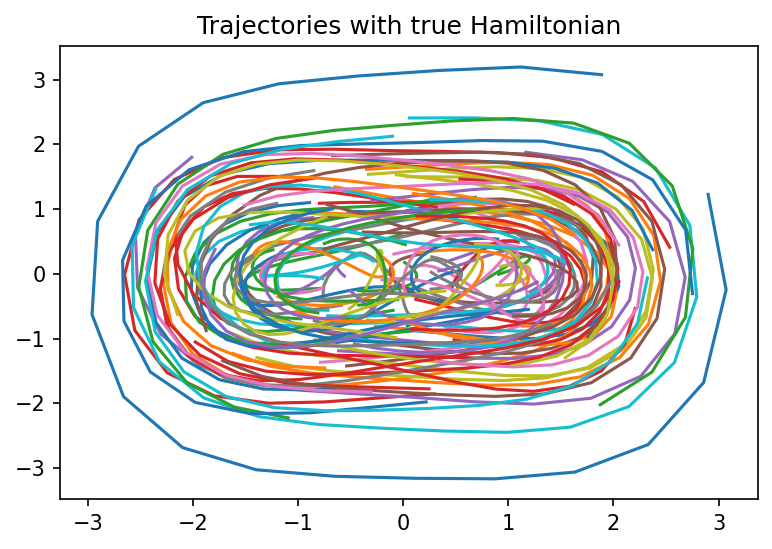

In [ ]:
fig, ax = plt.subplots(dpi=150)
Ztrue = np.zeros([N-Ntrain,2*s,len(timeEval)])
for i in range(N-Ntrain):
  Ztrue[i,:,:] = scipy.integrate.solve_ivp(system,[0, TT],z[Ntrain+i,:],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y
for i in range(N-Ntrain):
  ax.plot(Ztrue[i,0],Ztrue[i,2])
plt.title("Trajectories with true Hamiltonian")
plt.show()

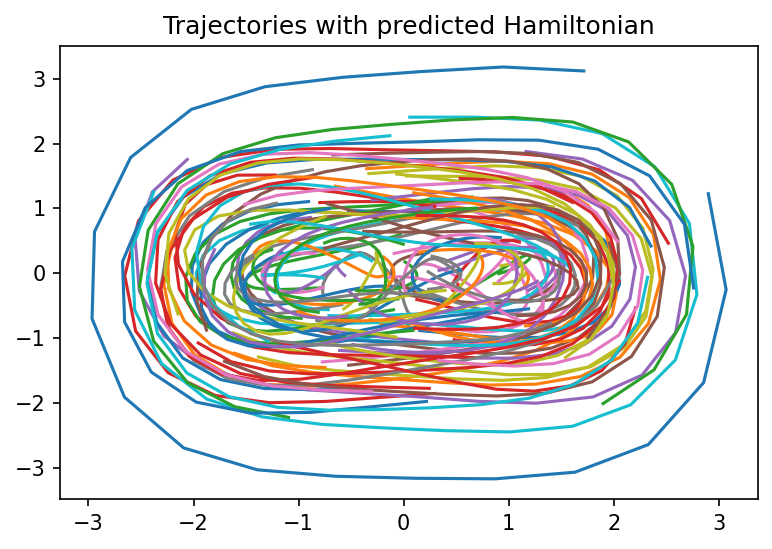

In [ ]:
fig, ax = plt.subplots(dpi=150)
Zpred = np.zeros([N-Ntrain,2*s,len(timeEval)])
for i in range(N-Ntrain):
  Zpred[i,:,:] = scipy.integrate.solve_ivp(perdictedModel,[0, TT],z[Ntrain+i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y
for i in range(N-Ntrain):
  ax.plot(Zpred[i,0],Zpred[i,2])
plt.title("Trajectories with predicted Hamiltonian")
plt.show()

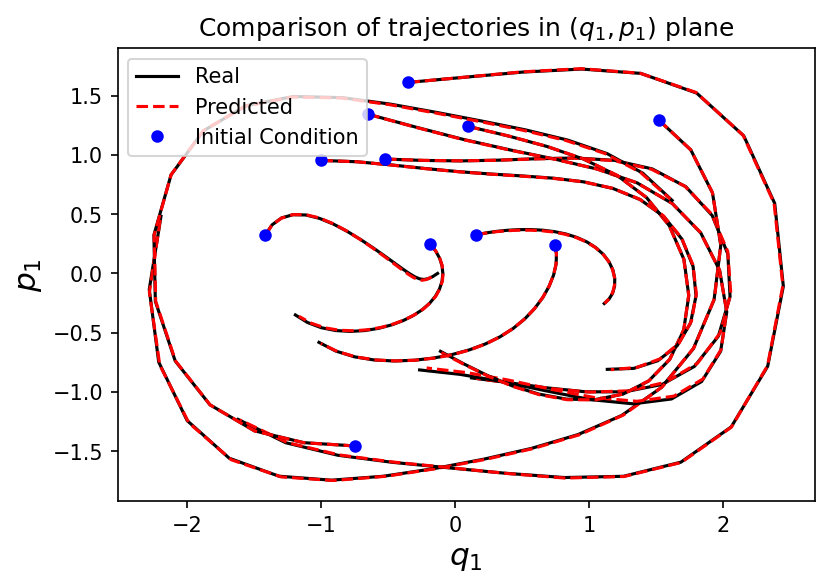

In [ ]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,0],Ztrue[0,2],'k-',markersize=3,label="Real")
ax.plot(Zpred[0,0],Zpred[0,2],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,N-Ntrain,10):
  #ax.plot(Ztrue[i,0,0],Ztrue[i,2,0],'r*',markersize=3)
  ax.plot(Ztrue[i,0],Ztrue[i,2],'k-',markersize=3)
  ax.plot(Zpred[i,0],Zpred[i,2],'r--',markersize=0.5)
  ax.plot(Zpred[i,0,0],Zpred[i,2,0],'bo',markersize=5)
  
ax.plot(Zpred[0,0,0],Zpred[0,2,0],'bo',markersize=5,label="Initial Condition")

ax.set_xlabel(r"$q_1$",fontsize=15)
ax.set_ylabel(r"$p_1$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_1,p_1)$ plane")
plt.legend()
plt.show()

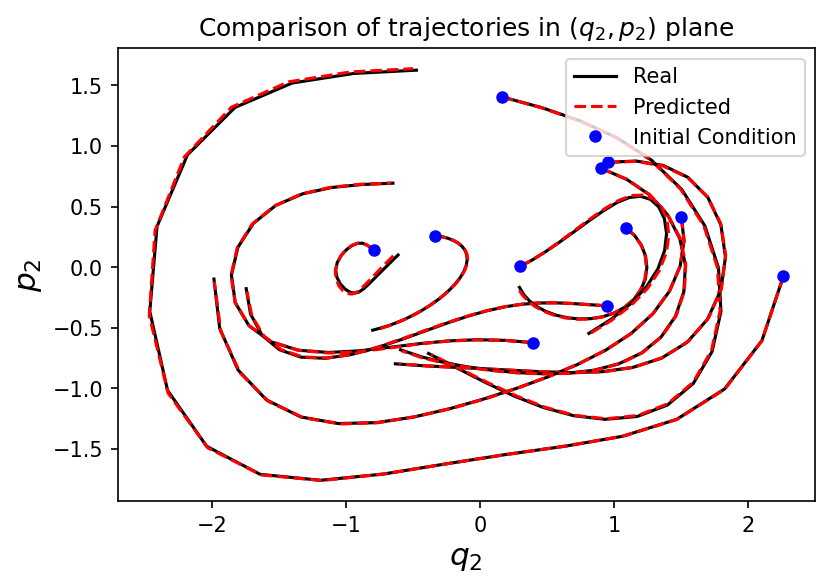

In [ ]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,1],Ztrue[0,3],'k-',markersize=3,label="Real")
ax.plot(Zpred[0,1],Zpred[0,3],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,N-Ntrain,10):
  ax.plot(Ztrue[i,1],Ztrue[i,3],'k-',markersize=3)
  ax.plot(Zpred[i,1],Zpred[i,3],'r--',markersize=0.5)
  ax.plot(Zpred[i,1,0],Zpred[i,3,0],'bo',markersize=5)
ax.plot(Zpred[0,1,0],Zpred[0,3,0],'bo',markersize=5,label="Initial Condition")
 
ax.set_xlabel(r"$q_2$",fontsize=15)
ax.set_ylabel(r"$p_2$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_2,p_2)$ plane")
plt.legend()
plt.show()

In [ ]:
cc = np.mean((Zpred-Ztrue)**2)

In [ ]:
print("MSE on test trajectories with RK45 as integrator: ",cc)

MSE on test trajectories with RK45 as integrator:  0.00017436202194681972
